## Importation of Necessary Module

In [1]:
import cv2
import json
import numpy as np
import os
import matplotlib.pyplot as plt
import numpy as np
import json

## Function to read image and show the load Image

The `read_img()` function takes two parameters: the directory where the image is stored and the image itself. Inside this function, we use the `cv2.imread()` function to read the image. Where `cv2.imread()` function from the OpenCV library read an as a NumPy array. By default, `cv2.imread()` reads the image in the BGR (Blue, Green, Red) color format. However, we need the image in the RGB (Red, Green, Blue) format instead. So, after reading the image, we convert it from BGR to RGB format. In nutsell the `read_img()` function return original image in numpy array format.

Similary `show()` function takes two parameters: image in ndarray format and fig_size by default fig_size is (10, 10) one can change it according their favor. The function of `show()` function is plot the given image.

In [2]:

def read_img(root_dir:str = r"/kaggle/input/orange-infection-mask-dataset/Orange_Image_Data/Orange_Image_Data",
             image: str = "IMG_20230829_145314_161.jpg"):
    original_image = cv2.imread(f"{root_dir}/{image}")  # Replace 'original_image.jpg' with your image file path
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    return original_image

def show(image: np.ndarray, fig_size = (10,10)):
    plt.imshow(image)
    plt.show()
    
                                


In [3]:
img = read_img()

In [ ]:
show(img)

## Load Image

The Orange dataset is labeled using **Label Studio**, employing two labels: "Healthy" and "Infected." Many images contain more than one occurrence of both Healthy and Infected labels within the same image. The file format for the Orange dataset is a JSON file generated by **Label Studio**. Consequently, a function named `load_label()` has been developed to extract images and their corresponding labels. The `load_label()` function takes one parameter, which is the file directory. The file is loaded using the `json.load()` function. Finally, `final_labels` and `label_counts`, are returned by the function in dictionary format.

In [3]:
def load_labels(labels_dir:str='/kaggle/input/orange-infection-mask-dataset/project-4-at-2024-03-02-15-13-497758b6.json'):
    
    with open(labels_dir, 'r') as f:  
         
        segmentation_data = json.load(f) 
        
    final_labels = {}
    label_counts = {}

    for sm in segmentation_data:
        
        img_name = "IMG"+sm['image'].split('-IMG')[1]
        img_dict = {}
         
        if sm.get('label') is None:
            continue
        
        for labels in sm['label']:
            width=labels['original_width']
            height = labels['original_height']
            
            points = np.array(labels['points']).reshape(-1, 2)
             
            points[:, 0] = points[:, 0] * width/100
            points[:, 1] = points[:, 1] * height/100
            
            
            label_names = labels['polygonlabels']
            
            for label_name in label_names:
                if img_dict.get(label_name) is None:
                    
                    img_dict[label_name] = []
                
                img_dict[label_name].append(points)
                
        
        final_labels[img_name]=img_dict
        
        label_counts[img_name] = {k:len(v) for k,v in img_dict.items()}
    return final_labels, label_counts
    
final_labels,_=load_labels()



Below code plot the sample 5 image from our dataset

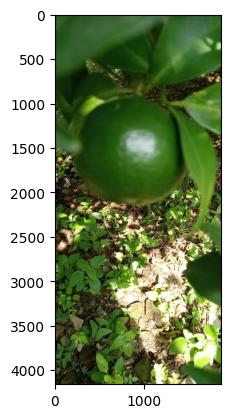

In [4]:
cnt = 0
for img_name,lbl in final_labels.items():
    cnt += 1
    if cnt >= 2:
        break
    img = read_img(image = img_name)
    show(img)


## Masking of Image According to Its Labels
`draw_mask()` function have two parameters: image and label. Colors that maps label names to their corresponding GR colors. Initializes three NumPy arrays of the same size as the input image, namely `blank_img`, `overlay_mask`, and `temp_img`, all with the data type np.uint8. Loops through each label in the label dictionary. For each label, extracts the associated mask coordinates and fills the `overlay_mask` array with the corresponding color. Finally display the mask image using `show()` function.

In [4]:
def draw_mask(image, label):
    
    colors={'Healthy':[0,255,0], 'Infected':[255,0,0]}
    
    blank_img = np.zeros_like(image, dtype=np.uint8) + 255  # Ensure blank_img has the correct data type
    overlay_mask = np.zeros_like(image, dtype=np.uint8)
    temp_img = image.copy()

    for label_name, masks in label.items():
        
        color = colors[label_name]
        for mask in masks:
            
            points = np.array(mask, np.int32)
            points = points.reshape((-1, 1, 2))[:,::-1]
            cv2.fillPoly(overlay_mask, [points], color)

        
        blank_img = cv2.addWeighted(blank_img, 0.7, overlay_mask, 0.3, 0)
        temp_img = cv2.addWeighted(temp_img, 0.7, overlay_mask, 0.3, 0)

    show(blank_img)
    show(temp_img)

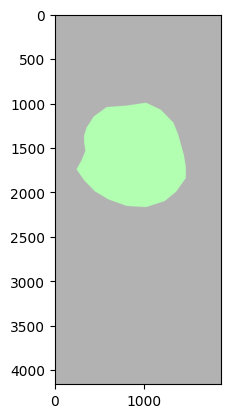

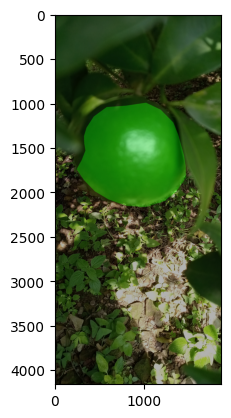

In [16]:
cnt = 0
for img_name,lbl in final_labels.items():
    cnt += 1
    if cnt >= 2:
        break
        
        
    img = read_img(image = img_name)
    draw_mask(img, lbl)
    

## Lets Drow Rectangular Mask on Every Orange Images

In [5]:


def draw_rectangles(image, label):
    
    colors = {'Healthy': [0, 255, 0], 'Infected': [255, 0, 0]}
    
    
    blank_img = np.zeros_like(image, dtype=np.uint8) + 255
    
    
    overlay_mask = np.zeros_like(image, dtype=np.uint8)
    
    
    temp_img = image.copy()

    
    for label_name, masks in label.items():
        color = colors[label_name]  # Get color for the current label
        for mask in masks:
            
            x1 = min(point[0] for point in mask)
            y1 = min(point[1] for point in mask)
            x2 = max(point[0] for point in mask)
            y2 = max(point[1] for point in mask)
            
            
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            
            cv2.rectangle(overlay_mask, (x1, y1), (x2, y2), color, -1)
        
        
        blank_img = cv2.addWeighted(blank_img, 0.7, overlay_mask, 0.3, 0)
        
        temp_img = cv2.addWeighted(temp_img, 0.7, overlay_mask, 0.3, 0)

    
    show(blank_img)
    show(temp_img)




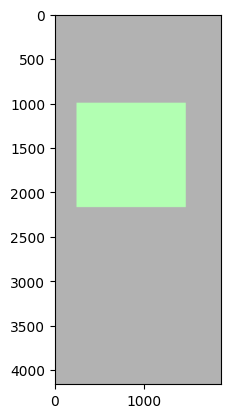

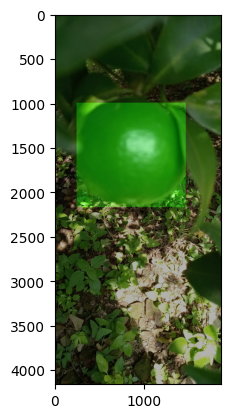

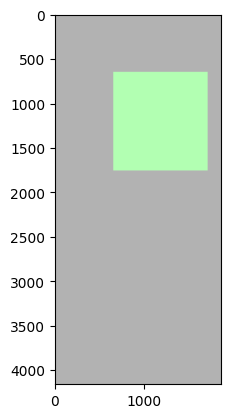

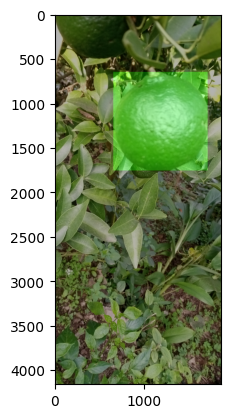

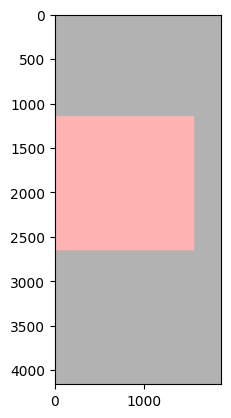

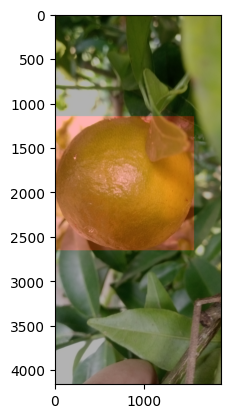

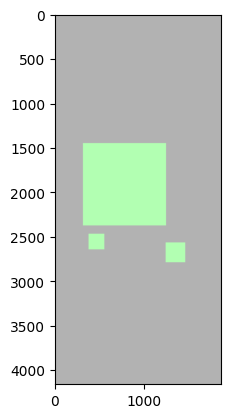

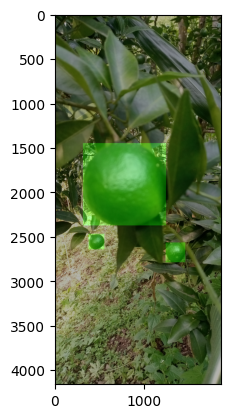

In [23]:
cnt = 0
for img_name,lbl in final_labels.items():
    cnt += 1
    if cnt >= 5:
        break
        
        
    img = read_img(image = img_name)
    draw_rectangles(img, lbl)
    

## Draw Rectangle Over Orange Images

In [6]:
def draw_rectangles(image, label):
    
    colors = {'Healthy': [0, 255, 0], 'Infected': [255, 0, 0]}
    
    
    blank_img = np.zeros_like(image, dtype=np.uint8) + 255
    
    
    overlay_mask = np.zeros_like(image, dtype=np.uint8)
    
    
    temp_img = image.copy()

    
    for label_name, masks in label.items():
        color = colors[label_name]  
        for mask in masks:
            
            x1 = min(point[0] for point in mask)
            y1 = min(point[1] for point in mask)
            x2 = max(point[0] for point in mask)
            y2 = max(point[1] for point in mask)
            
            
            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
            
            
            cv2.rectangle(overlay_mask, (x1, y1), (x2, y2), color, 10, lineType=cv2.LINE_AA)
        
        
        blank_img = cv2.addWeighted(blank_img, 0.7, overlay_mask, 0.3, 0)
        
        temp_img = cv2.addWeighted(temp_img, 0.7, overlay_mask, 0.3, 0)

    
    show(blank_img)
    show(temp_img)




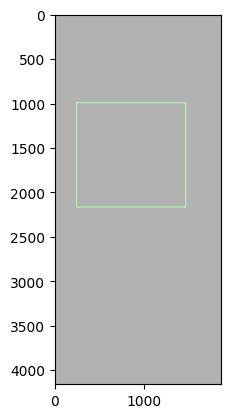

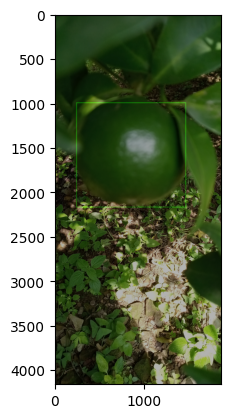

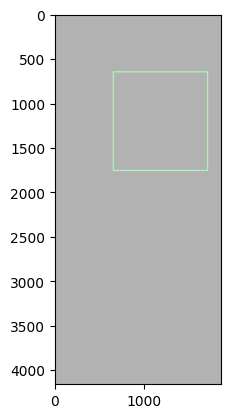

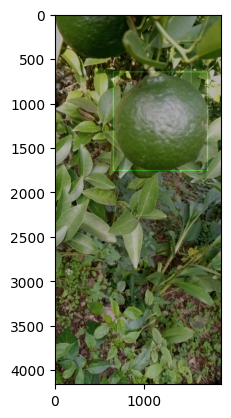

In [31]:
cnt = 0
for img_name,lbl in final_labels.items():
    cnt += 1
    if cnt >= 3:
        break
        
        
    img = read_img(image = img_name)
    draw_rectangles(img, lbl)
    

## Draw Circular Mask Over Orange Images

In [35]:
import numpy as np
import cv2

def draw_circles(image, label):
    
    colors = {'Healthy': [0, 255, 0], 'Infected': [255, 0, 0]}
    
    
    blank_img = np.zeros_like(image, dtype=np.uint8) + 255
    
    
    overlay_mask = np.zeros_like(image, dtype=np.uint8)
    
    
    temp_img = image.copy()

    
    for label_name, masks in label.items():
        color = colors[label_name]  
        for mask in masks:
            
            center = (int(np.mean([point[0] for point in mask])), int(np.mean([point[1] for point in mask])))
            radius = int(max(abs(point[0] - center[0]) for point in mask))
            
            
            cv2.circle(overlay_mask, center, radius, color, -1)  # Thickness = 4 for example
            
        
        blank_img = cv2.addWeighted(blank_img, 0.7, overlay_mask, 0.3, 0)
        
        temp_img = cv2.addWeighted(temp_img, 0.7, overlay_mask, 0.3, 0)

    
    show(blank_img)
    show(temp_img)



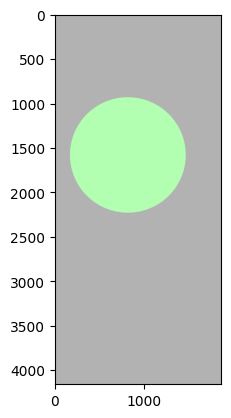

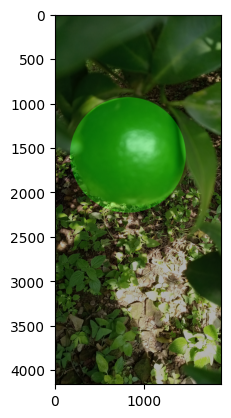

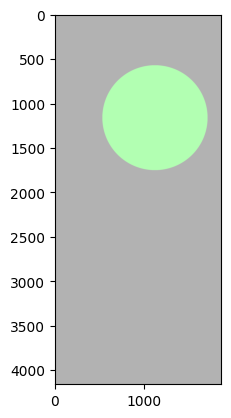

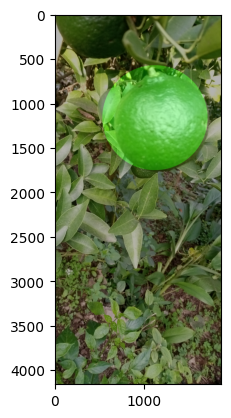

In [36]:
cnt = 0
for img_name,lbl in final_labels.items():
    cnt += 1
    if cnt >= 3:
        break
        
        
    img = read_img(image = img_name)
    draw_circles(img, lbl)
    

## Getting only The masked Region of a Image

### Look for some images

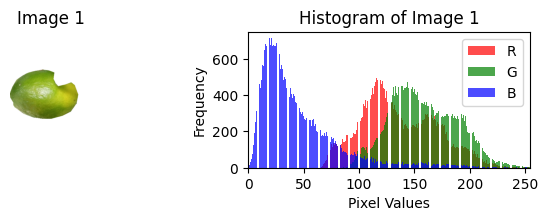

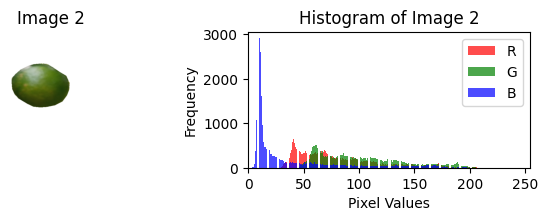

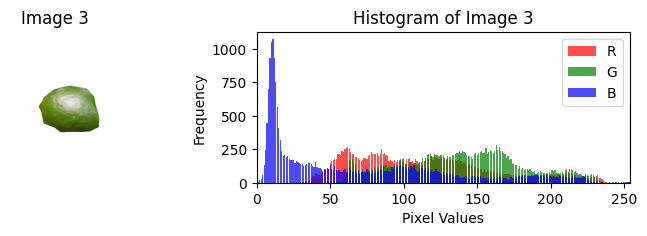

In [7]:
def get_masked_region(labels_dict, root:str="/kaggle/input/orange-infection-mask-dataset/Orange_Image_Data/Orange_Image_Data/", 
                      num_images=10, label:str='Infected', out_shape= (300, 500),
                     get_img=True, get_pix_cnt=True):
    """
    labels_dict: {label: [points]}
    num_images: -1 gives all
    label: Healthy or Infected
    out_shape: final output shape (w,h)
    """
    images = []
    num = 0
    pix_cnts=[]
    all_pix_cnt={'R':{}, 'G':{}, 'B':{}}
    for img_name, lbl in labels_dict.items():
        pix_cnt={'R':{}, 'G':{}, 'B':{}}
        if num_images==-1 or num_images>=num:
            points = lbl.get(label)
            if points is None:
                continue
            img = cv2.imread(root+img_name)
            h,w,c = img.shape
            blank_img = np.zeros((h,w,3), dtype=np.uint8)+255
            # we want to get only infected/healthy regions of an image
            for point in points:
                point = np.array(point)
                point = point.astype(np.int32)
                
                # draw black pixels where the mask covers it
                cv2.fillPoly(blank_img, [point], [0,0,0])
            
            # take those pixels where pixel values are not black
            blank_img[blank_img==[0,0,0]] = img[blank_img==[0,0,0]]
            blank_img=cv2.resize(blank_img, out_shape)
            if get_img:
                images.append(blank_img)
                    
            for row in blank_img:
                for pix in row:
                    if (pix==np.array([255,255,255])).all():
                        continue
                    b,g,r=pix
                    if pix_cnt['B'].get(b) is None:
                        pix_cnt['B'][b]=0
                    pix_cnt['B'][b]+=1

                    if pix_cnt['G'].get(g) is None:
                        pix_cnt['G'][g]=0
                    pix_cnt['G'][g]+=1

                    if pix_cnt['R'].get(r) is None:
                        pix_cnt['R'][r]=0
                    pix_cnt['R'][r]+=1
                    
                    if all_pix_cnt['B'].get(b) is None:
                        all_pix_cnt['B'][b]=0
                    all_pix_cnt['B'][b]+=1

                    if all_pix_cnt['G'].get(g) is None:
                        all_pix_cnt['G'][g]=0
                    all_pix_cnt['G'][g]+=1

                    if all_pix_cnt['R'].get(r) is None:
                        all_pix_cnt['R'][r]=0
                    all_pix_cnt['R'][r]+=1
                    
            pix_cnts.append(pix_cnt)
            
                
        else:
            break
        num+=1
    return images, pix_cnts, all_pix_cnt
regions,pix_cnts, all_pix_cnt = get_masked_region(final_labels, num_images=2)

i=0
for region, pix_cnt in zip(regions,pix_cnts):
    plt.figure(figsize=(8, 6))
    plt.subplot(len(regions), 2, 2 * i + 1)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i + 1}")
    plt.axis("off")

    plt.subplot(len(regions), 2, 2 * i + 2)
    for channel, color in zip(['R', 'G', 'B'], ['red', 'green', 'blue']):
        plt.bar(pix_cnt[channel].keys(), pix_cnt[channel].values(),  
                alpha=0.7, label=channel, color=color)
    plt.xlim([0, 254])  # Limit histogram to 254 pixels
    plt.title(f"Histogram of Image {i + 1}")
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")
    plt.legend()
    i+=1

plt.tight_layout()
plt.show()


### In entire Dataset: Infected

In [8]:
regions,pix_cnts, all_pix_cnt = get_masked_region(final_labels, num_images=-1, get_img=False)
 

i=0
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 2 * i + 1)
plt.imshow(np.zeros((400,400,3)))
plt.title(f"Image {i + 1}")
plt.axis("off")

plt.subplot(2, 2, 2 * i + 2)
for channel, color in zip(['R', 'G', 'B'], ['red', 'green', 'blue']):
    plt.bar(all_pix_cnt[channel].keys(), all_pix_cnt[channel].values(),  
            alpha=0.7, label=channel, color=color)
plt.xlim([0, 254])  # Limit histogram to 254 pixels
plt.title(f"Histogram of Image {i + 1}")
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

### Healthy

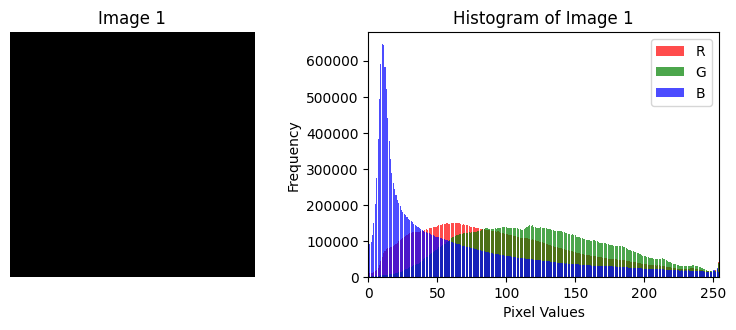

In [10]:
regions,pix_cnts, all_pix_cnt = get_masked_region(final_labels, 
                                                  label='Healthy',
                                                  num_images=-1, get_img=False)
 

i=0
plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 2 * i + 1)
plt.imshow(np.zeros((400,400,3)))
plt.title(f"Image {i + 1}")
plt.axis("off")

plt.subplot(2, 2, 2 * i + 2)
for channel, color in zip(['R', 'G', 'B'], ['red', 'green', 'blue']):
    plt.bar(all_pix_cnt[channel].keys(), all_pix_cnt[channel].values(),  
            alpha=0.7, label=channel, color=color)
plt.xlim([0, 254])  
plt.title(f"Histogram of Image {i + 1}")
plt.xlabel("Pixel Values")
plt.ylabel("Frequency")
plt.legend()

plt.tight_layout()
plt.show()

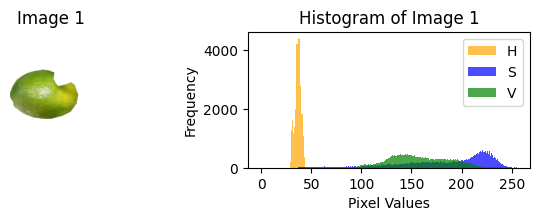

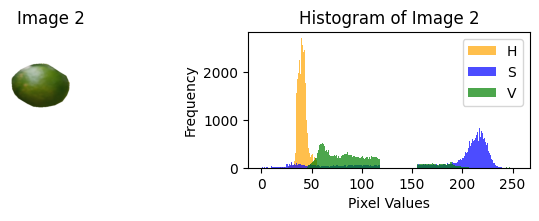

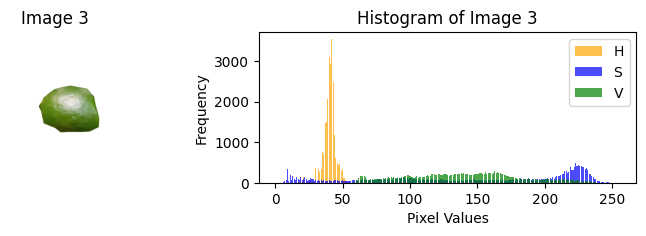

In [10]:
def get_masked_region(labels_dict, root="/kaggle/input/orange-infection-mask-dataset/Orange_Image_Data/Orange_Image_Data/", 
                      num_images=10, label='Infected', out_shape=(300, 500),
                      get_img=True, get_pix_cnt=True):
    

    images = []
    num = 0
    pix_cnts = []
    all_pix_cnt = {'H': {}, 'S': {}, 'V': {}}

    for img_name, lbl in labels_dict.items():
        pix_cnt = {'H': {}, 'S': {}, 'V': {}}

        if num_images == -1 or num_images >= num:
            points = lbl.get(label)
            if points is None:
                continue
            
            img = cv2.imread(os.path.join(root, img_name))
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

            h, w, _ = img.shape
            blank_img = np.zeros((h, w, 3), dtype=np.uint8) + 255

            
            for point in points:
                point = np.array(point)
                point = point.astype(np.int32)
                cv2.fillPoly(blank_img, [point], [0, 0, 0])

            
            blank_img[blank_img == [0, 0, 0]] = img[blank_img == [0, 0, 0]]
            blank_img = cv2.resize(blank_img, out_shape)

            if get_img:
                images.append(blank_img)

            
            if get_pix_cnt:
                for row in blank_img:
                    for pix in row:
                        if (pix == np.array([255, 255, 255])).all():
                            continue
                        h, s, v = cv2.split(cv2.cvtColor(np.uint8([[pix]]), cv2.COLOR_BGR2HSV))
                        pix_cnt['H'].setdefault(h[0][0], 0)
                        pix_cnt['H'][h[0][0]] += 1
                        pix_cnt['S'].setdefault(s[0][0], 0)
                        pix_cnt['S'][s[0][0]] += 1
                        pix_cnt['V'].setdefault(v[0][0], 0)
                        pix_cnt['V'][v[0][0]] += 1

                        all_pix_cnt['H'].setdefault(h[0][0], 0)
                        all_pix_cnt['H'][h[0][0]] += 1
                        all_pix_cnt['S'].setdefault(s[0][0], 0)
                        all_pix_cnt['S'][s[0][0]] += 1
                        all_pix_cnt['V'].setdefault(v[0][0], 0)
                        all_pix_cnt['V'][v[0][0]] += 1

                pix_cnts.append(pix_cnt)

        else:
            break
        num += 1

    return images, pix_cnts, all_pix_cnt


regions, pix_cnts, all_pix_cnt = get_masked_region(final_labels, root="/kaggle/input/orange-infection-mask-dataset/Orange_Image_Data/Orange_Image_Data/", num_images=2)

i = 0
for region, pix_cnt in zip(regions, pix_cnts):
    plt.figure(figsize=(8, 6))
    plt.subplot(len(regions), 2, 2 * i + 1)
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_BGR2RGB))
    plt.title(f"Image {i + 1}")
    plt.axis("off")

    plt.subplot(len(regions), 2, 2 * i + 2)
    for channel, color in zip(['H', 'S', 'V'], ['orange', 'blue', 'green']):
        plt.bar(pix_cnt[channel].keys(), pix_cnt[channel].values(),  
                alpha=0.7, label=channel, color=color)
    plt.title(f"Histogram of Image {i + 1}")
    plt.xlabel("Pixel Values")
    plt.ylabel("Frequency")
    plt.legend()
    i += 1

plt.tight_layout()
plt.show()


## 

## Class To Make The Dataset Ready for Segmentation Model

In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
import numpy as np

In [10]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import json
import numpy as np

class MultiMaskSegmentationDataset(Dataset):
    def __init__(self, root_dir, labels_file, transform=None):
        self.root_dir = root_dir
        self.labels_file = labels_file
        self.transform = transform
        self.images_dir = root_dir
        
        self.labels, self.label_counts = self.load_labels(labels_file)

    def load_labels(self, labels_dir):
        
        
        with open(labels_dir, 'r') as f:
            segmentation_data = json.load(f)

        final_labels = {}
        label_counts = {}
        self.label_names = []
        

        for sm in segmentation_data:
            img_name = "IMG"+sm['image'].split('-IMG')[1]
           
            img_dict = {}

            if sm.get('label') is None:
                continue

            for labels in sm['label']:
                width = labels['original_width']
                height = labels['original_height']
                points = np.array(labels['points']).reshape(-1, 2)
                points[:, 0] = points[:, 0] * width / 100
                points[:, 1] = points[:, 1] * height / 100

                label_names = labels['polygonlabels']
                
                for label_name in label_names:
                    self.label_names.append(label_name)
                    if img_dict.get(label_name) is None:
                        img_dict[label_name] = []
                    img_dict[label_name].append(points)

            final_labels[img_name] = img_dict
            label_counts[img_name] = {k: len(v) for k, v in img_dict.items()}
            
        self.label_names = sorted(list(set(self.label_names)))
        return final_labels, label_counts

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = list(self.labels.keys())[idx]
        img_path = os.path.join(self.images_dir, img_name)

        
        image = Image.open(img_path).convert("RGB")
        

        
        
        healthy = np.zeros(image.size[::-1], dtype = np.uint8)
        infected = np.zeros(image.size[::-1], dtype = np.uint8)
        masks = {"Healthy":healthy, "Infected": infected}
        for label_name, points_list in self.labels[img_name].items():
            mask = masks.get(label_name)


            
            for points in points_list:
                points = np.round(points).astype(int)
                mask = cv2.fillPoly(mask, [points], 255)

            masks[label_name] = mask
        masks =[Image.fromarray(mask) for mask in  masks.values()]
        

        if self.transform:
            image = self.transform(image)
            masks = [self.transform(mask) for mask in masks]

        return image, masks


transform = transforms.Compose([
    transforms.Resize((256, 256)), 
    transforms.ToTensor(),
])


labels_file = '/kaggle/input/orange-infection-mask-dataset/project-4-at-2024-03-02-15-13-497758b6.json'


dataset = MultiMaskSegmentationDataset(root_dir='/kaggle/input/orange-infection-mask-dataset/Orange_Image_Data/Orange_Image_Data/', labels_file=labels_file, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)



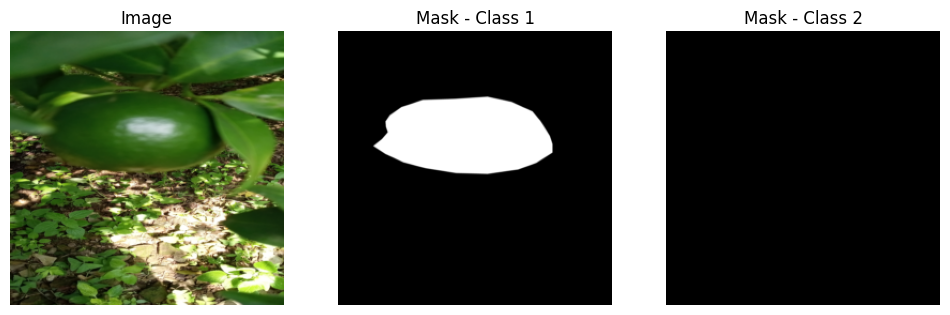

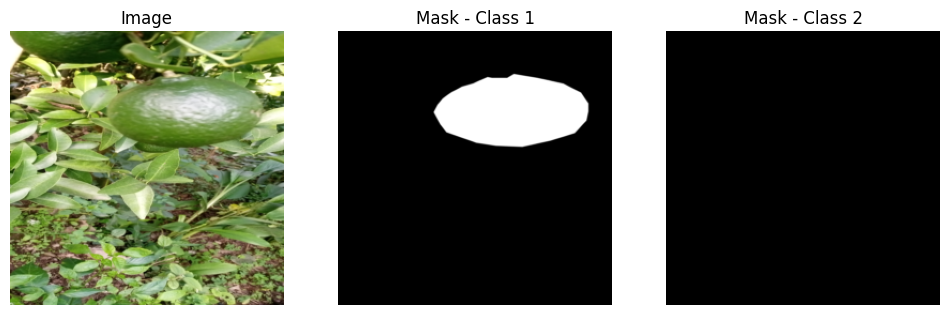

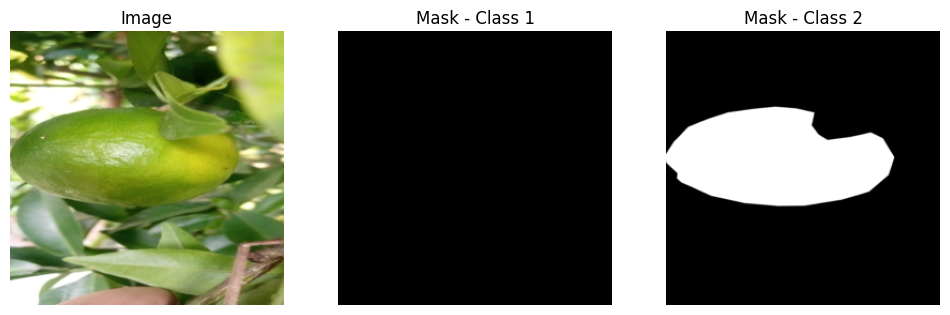

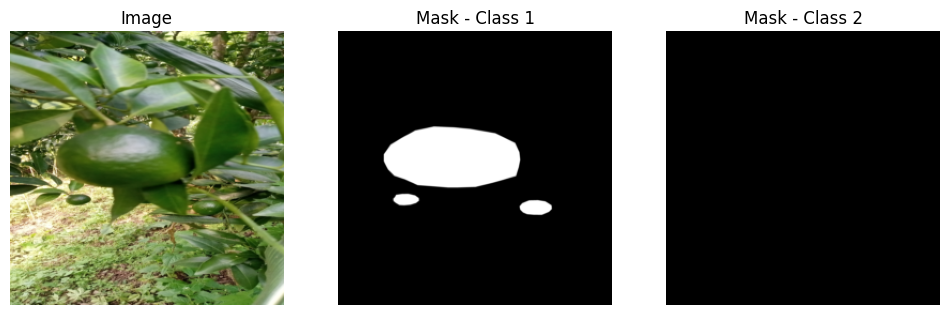

In [11]:
import matplotlib.pyplot as plt
import torch.nn.functional as F


num_examples = 4


for i in range(num_examples):
    
    image, masks = dataset[i]

    
    image = image.permute(1, 2, 0).numpy()
    
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, len(masks) + 1, 1)
    plt.imshow(image)
    plt.title('Image')
    plt.axis('off')

   
    for j, mask in enumerate(masks):
        mask = mask.squeeze().numpy()  
        plt.subplot(1, len(masks) + 1, j + 2)
        plt.imshow(mask, cmap='gray')
        plt.title(f'Mask - Class {j + 1}')
        plt.axis('off')

    plt.show()
